In [22]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('whitegrid')

## 1. Theoretical Background

### Multiple Linear Regression
Standard regression predicting continuous target: $\hat{y} = \beta_0 + \sum_{i=1}^{n} \beta_i x_i$

**Cost Function (OLS):** $J(\beta) = \frac{1}{2m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)})^2$

**Limitation:** Sensitive to multicollinearity; correlated features cause unstable coefficient estimates.

### Ridge Regression (L2 Regularization)
Adds L2 penalty to shrink coefficients: $J(\beta) = \frac{1}{2m} \sum (\hat{y} - y)^2 + \lambda \sum \beta_j^2$

**Effect:** Reduces variance by distributing weight across correlated features (shrinks but rarely sets coefficients to zero)  
**Closed-form solution:** $\beta = (X^T X + \lambda I)^{-1} X^T y$

### Lasso Regression (L1 Regularization)
Adds L1 penalty for feature selection: $J(\beta) = \frac{1}{2m} \sum (\hat{y} - y)^2 + \lambda \sum |\beta_j|$

**Effect:** Drives some coefficients exactly to zero (feature selection)  
**Trade-off:** If features are highly correlated, Lasso arbitrarily selects one and zeros others

**Key Difference:** Ridge shrinks all coefficients proportionally; Lasso performs automatic feature selection.

## 2. Dataset & Methodology

**Insurance Premium Dataset:**
- 1,338 individuals with medical insurance data
- 6 features: age (18-64), sex (binary), BMI (15.96-53.13), children (0-5), smoker (binary), region (4 categories)
- Target: Individual medical costs charged by insurance (continuous, right-skewed)
- Challenge: Smoking status has strong non-linear impact on costs

**Methodology:**
1. Load data and visualize distributions & correlations
2. Encode categorical variables (sex, smoker, region)
3. Standardize features (critical for regularization)
4. Train-Test split 70-30
5. Train three models: Linear, Lasso, Ridge
6. Evaluate with R², RMSE, MAE
7. Analyze coefficient differences across models
8. Tune regularization parameter (alpha) via GridSearchCV
9. Compare model performance and identify best model

## 3. Dataset Loading & EDA

In [23]:
try:
    df = pd.read_csv('insurance.csv')
    print(f"Loaded: {df.shape[0]} samples, {df.shape[1]} features")
    print(f"\nFeature types:")
    print(df.dtypes)
except FileNotFoundError:
    print("File not found. Download from: https://www.kaggle.com/datasets/noordeen/insurance-premium-prediction")
    df = None

Loaded: 1338 samples, 7 features

Feature types:
age           int64
sex             str
bmi         float64
children      int64
smoker          str
region          str
expenses    float64
dtype: object


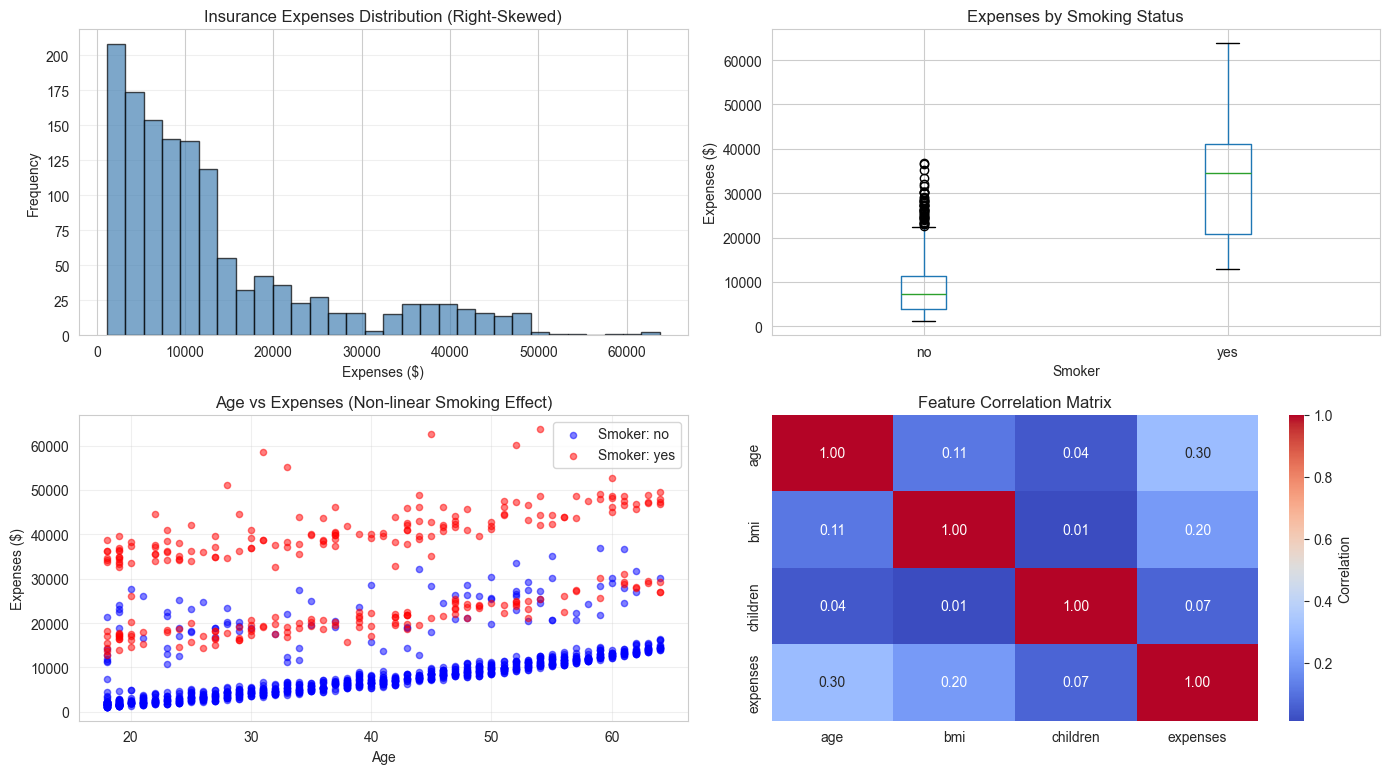

In [24]:
if df is not None:
    # Reload original data for visualization (fresh copy)
    try:
        df_viz = pd.read_csv('insurance.csv')
    except FileNotFoundError:
        df_viz = df.copy()
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    
    # Expenses distribution
    axes[0, 0].hist(df_viz['expenses'], bins=30, edgecolor='black', color='steelblue', alpha=0.7)
    axes[0, 0].set_xlabel('Expenses ($)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Insurance Expenses Distribution (Right-Skewed)')
    axes[0, 0].grid(alpha=0.3, axis='y')
    
    # Expenses by smoker status
    df_viz.boxplot(column='expenses', by='smoker', ax=axes[0, 1])
    axes[0, 1].set_title('Expenses by Smoking Status')
    axes[0, 1].set_xlabel('Smoker')
    axes[0, 1].set_ylabel('Expenses ($)')
    plt.sca(axes[0, 1])
    plt.xticks([1, 2], ['no', 'yes'])
    plt.suptitle(None)
    
    # Age vs Expenses
    for smoker, color in zip(['no', 'yes'], ['blue', 'red']):
        mask = df_viz['smoker'] == smoker
        axes[1, 0].scatter(df_viz[mask]['age'], df_viz[mask]['expenses'], alpha=0.5, s=20, label=f'Smoker: {smoker}', color=color)
    axes[1, 0].set_xlabel('Age')
    axes[1, 0].set_ylabel('Expenses ($)')
    axes[1, 0].set_title('Age vs Expenses (Non-linear Smoking Effect)')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    
    # Correlation heatmap (numeric only)
    num_df = df_viz.select_dtypes(include=[np.number])
    sns.heatmap(num_df.corr(), annot=True, fmt='.2f', cmap='coolwarm', ax=axes[1, 1], cbar_kws={'label': 'Correlation'})
    axes[1, 1].set_title('Feature Correlation Matrix')
    
    plt.tight_layout()
    plt.show()


## 4. Data Preprocessing

In [25]:
if df is not None:
    df_proc = df.copy()
    
    # Encode categorical variables
    le_sex = LabelEncoder()
    le_smoker = LabelEncoder()
    le_region = LabelEncoder()
    
    df_proc['sex'] = le_sex.fit_transform(df_proc['sex'])
    df_proc['smoker'] = le_smoker.fit_transform(df_proc['smoker'])
    df_proc['region'] = le_region.fit_transform(df_proc['region'])
    
    X = df_proc.drop('expenses', axis=1)
    y = df_proc['expenses']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    
    print(f"Train: {X_train.shape[0]} | Test: {X_test.shape[0]} | Features: {X_train.shape[1]}")
    print(f"Target range: ${y.min():.2f} - ${y.max():.2f} | Mean: ${y.mean():.2f}")


Train: 936 | Test: 402 | Features: 6
Target range: $1121.87 - $63770.43 | Mean: $13270.42


## 5. Model Training & Comparison

In [26]:
if df is not None:
    # Multiple Linear Regression
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)
    y_train_lr = lr.predict(X_train_scaled)
    y_test_lr = lr.predict(X_test_scaled)
    
    # Lasso Regression
    lasso = Lasso(alpha=100, random_state=42, max_iter=5000)
    lasso.fit(X_train_scaled, y_train)
    y_train_lasso = lasso.predict(X_train_scaled)
    y_test_lasso = lasso.predict(X_test_scaled)
    
    # Ridge Regression
    ridge = Ridge(alpha=100, random_state=42)
    ridge.fit(X_train_scaled, y_train)
    y_train_ridge = ridge.predict(X_train_scaled)
    y_test_ridge = ridge.predict(X_test_scaled)
    
    print("Models trained successfully")

Models trained successfully


In [27]:
if df is not None:
    # Feature coefficients comparison
    coef_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Linear': lr.coef_,
        'Lasso': lasso.coef_,
        'Ridge': ridge.coef_
    })
    print("\nFeature Coefficients (default alpha=100):")
    print(coef_df.to_string(index=False))
    print(f"\nNote: Lasso zeros: {(coef_df['Lasso'] == 0).sum()} features | Ridge keeps all features")


Feature Coefficients (default alpha=100):
 Feature      Linear       Lasso       Ridge
     age 3693.032582 3604.296052 3314.390825
     sex   54.903886    0.000000   88.272495
     bmi 2065.227103 1952.598518 1887.732193
children  514.679502  426.273315  506.429378
  smoker 9592.597777 9492.737053 8648.911177
  region -362.952542 -246.239900 -295.403679

Note: Lasso zeros: 1 features | Ridge keeps all features


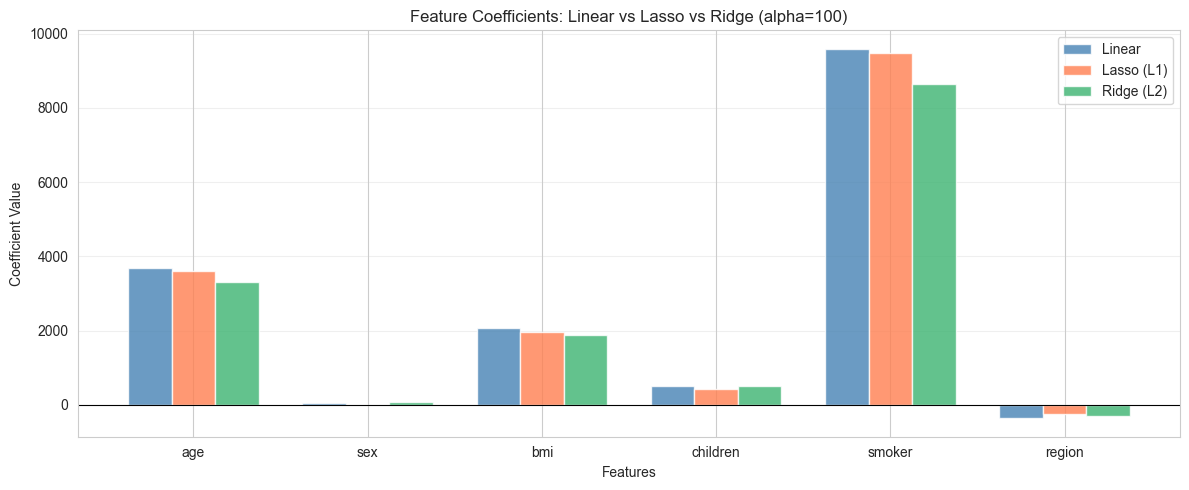

In [28]:
if df is not None:
    fig, ax = plt.subplots(figsize=(12, 5))
    x = np.arange(len(coef_df))
    width = 0.25
    
    ax.bar(x - width, coef_df['Linear'], width, label='Linear', alpha=0.8, color='steelblue')
    ax.bar(x, coef_df['Lasso'], width, label='Lasso (L1)', alpha=0.8, color='coral')
    ax.bar(x + width, coef_df['Ridge'], width, label='Ridge (L2)', alpha=0.8, color='mediumseagreen')
    
    ax.set_ylabel('Coefficient Value')
    ax.set_xlabel('Features')
    ax.set_title('Feature Coefficients: Linear vs Lasso vs Ridge (alpha=100)')
    ax.set_xticks(x)
    ax.set_xticklabels(coef_df['Feature'], rotation=0)
    ax.legend()
    ax.grid(alpha=0.3, axis='y')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    plt.tight_layout()
    plt.show()

## 6. Performance Evaluation

In [29]:
if df is not None:
    # Calculate metrics for all models
    models = {'Linear': (y_test_lr, y_train_lr), 'Lasso': (y_test_lasso, y_train_lasso), 'Ridge': (y_test_ridge, y_train_ridge)}
    results = []
    
    for name, (y_pred_test, y_pred_train) in models.items():
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)
        test_mse = mean_squared_error(y_test, y_pred_test)
        test_rmse = np.sqrt(test_mse)
        test_mae = mean_absolute_error(y_test, y_pred_test)
        results.append({'Model': name, 'Train R²': train_r2, 'Test R²': test_r2, 'RMSE': test_rmse, 'MAE': test_mae})
    
    results_df = pd.DataFrame(results)
    print("Model Performance Summary (alpha=100):")
    print(results_df.to_string(index=False))


Model Performance Summary (alpha=100):
 Model  Train R²  Test R²        RMSE         MAE
Linear  0.742269 0.769463 5813.981730 4154.700387
 Lasso  0.741899 0.769296 5816.083516 4146.559651
 Ridge  0.735140 0.760615 5924.500631 4330.591225


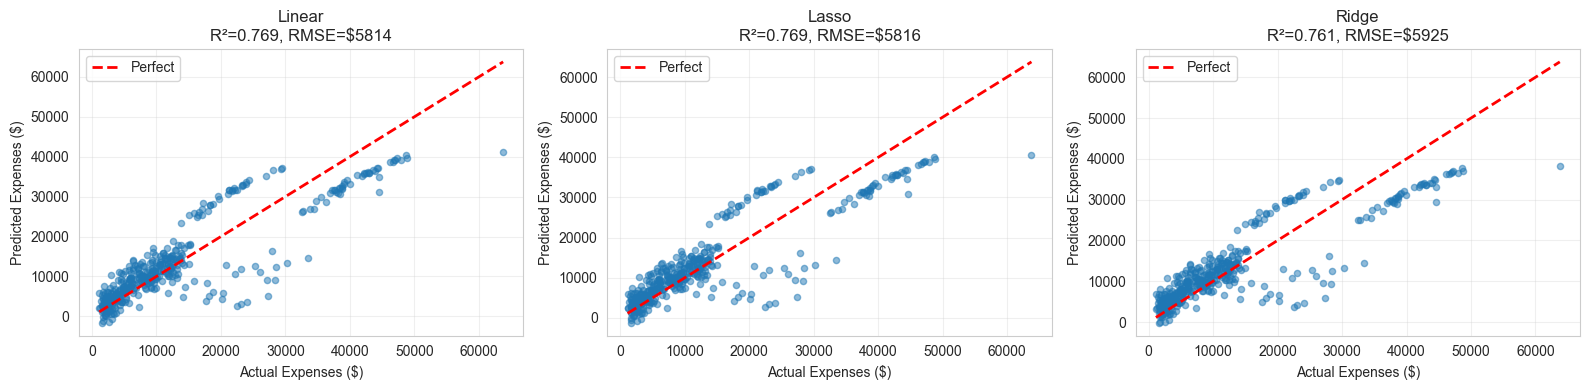

In [30]:
if df is not None:
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    
    predictions = [('Linear', y_test_lr), ('Lasso', y_test_lasso), ('Ridge', y_test_ridge)]
    
    for idx, (name, y_pred) in enumerate(predictions):
        axes[idx].scatter(y_test, y_pred, alpha=0.5, s=20)
        axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect')
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        axes[idx].set_xlabel('Actual Expenses ($)')
        axes[idx].set_ylabel('Predicted Expenses ($)')
        axes[idx].set_title(f'{name}\nR²={r2:.3f}, RMSE=${rmse:.0f}')
        axes[idx].legend()
        axes[idx].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


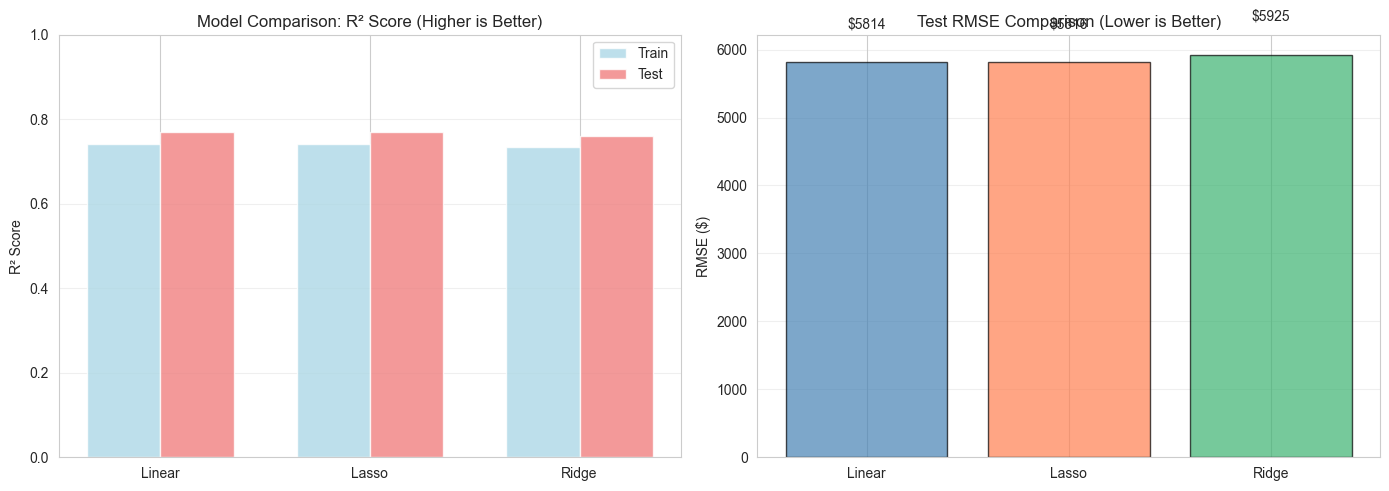

In [ ]:
if df is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # R² comparison
    r2_train = [r2_score(y_train, y_train_lr), r2_score(y_train, y_train_lasso), r2_score(y_train, y_train_ridge)]
    r2_test = [r2_score(y_test, y_test_lr), r2_score(y_test, y_test_lasso), r2_score(y_test, y_test_ridge)]
    models_list = ['Linear', 'Lasso', 'Ridge']
    
    x = np.arange(len(models_list))
    width = 0.35
    axes[0].bar(x - width/2, r2_train, width, label='Train', alpha=0.8, color='lightblue')
    axes[0].bar(x + width/2, r2_test, width, label='Test', alpha=0.8, color='lightcoral')
    axes[0].set_ylabel('R² Score')
    axes[0].set_title('Model Comparison: R² Score (Higher is Better)')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(models_list)
    axes[0].legend()
    axes[0].grid(alpha=0.3, axis='y')
    axes[0].set_ylim([0, 1])
    
    # RMSE comparison (lower is better)
    rmse = [np.sqrt(mean_squared_error(y_test, y_test_lr)), np.sqrt(mean_squared_error(y_test, y_test_lasso)), np.sqrt(mean_squared_error(y_test, y_test_ridge))]
    colors_rmse = ['steelblue', 'coral', 'mediumseagreen']
    axes[1].bar(models_list, rmse, color=colors_rmse, alpha=0.7, edgecolor='black')
    axes[1].set_ylabel('RMSE ($)')
    axes[1].set_title('Test RMSE Comparison (Lower is Better)')
    axes[1].grid(alpha=0.3, axis='y')
    for i, v in enumerate(rmse):
        axes[1].text(i, v + 500, f'${v:.0f}', ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()


## 7. Hyperparameter Tuning

Regularization parameter alpha controls the strength of penalty. For Ridge & Lasso:  
- **Small alpha:** Weak regularization, model closer to unregularized (high variance)  
- **Large alpha:** Strong regularization, more coefficients shrink (high bias)  

GridSearchCV finds optimal alpha using cross-validation to minimize test error.

In [32]:
if df is not None:
    print("Tuning Lasso alpha parameter...")
    alphas = np.logspace(-3, 3, 25)
    lasso_r2_train = []
    lasso_r2_test = []
    
    for alpha in alphas:
        lasso_temp = Lasso(alpha=alpha, random_state=42, max_iter=5000)
        lasso_temp.fit(X_train_scaled, y_train)
        lasso_r2_train.append(r2_score(y_train, lasso_temp.predict(X_train_scaled)))
        lasso_r2_test.append(r2_score(y_test, lasso_temp.predict(X_test_scaled)))
    
    print("\nTuning Ridge alpha parameter...")
    ridge_r2_train = []
    ridge_r2_test = []
    
    for alpha in alphas:
        ridge_temp = Ridge(alpha=alpha, random_state=42)
        ridge_temp.fit(X_train_scaled, y_train)
        ridge_r2_train.append(r2_score(y_train, ridge_temp.predict(X_train_scaled)))
        ridge_r2_test.append(r2_score(y_test, ridge_temp.predict(X_test_scaled)))
    
    best_lasso_alpha = alphas[np.argmax(lasso_r2_test)]
    best_ridge_alpha = alphas[np.argmax(ridge_r2_test)]
    
    print(f"\nBest Lasso alpha: {best_lasso_alpha:.4f} (Test R²={max(lasso_r2_test):.4f})")
    print(f"Best Ridge alpha: {best_ridge_alpha:.4f} (Test R²={max(ridge_r2_test):.4f})")

Tuning Lasso alpha parameter...

Tuning Ridge alpha parameter...

Best Lasso alpha: 56.2341 (Test R²=0.7696)
Best Ridge alpha: 0.0010 (Test R²=0.7695)


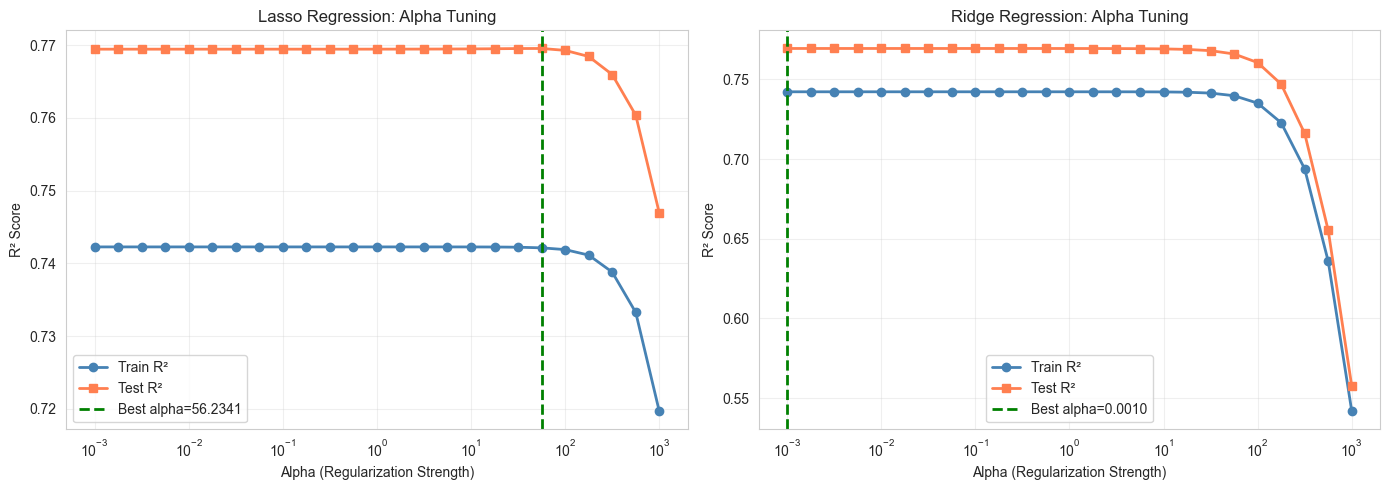

In [33]:
if df is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Lasso alpha tuning
    axes[0].plot(alphas, lasso_r2_train, 'o-', label='Train R²', linewidth=2, markersize=6, color='steelblue')
    axes[0].plot(alphas, lasso_r2_test, 's-', label='Test R²', linewidth=2, markersize=6, color='coral')
    axes[0].axvline(x=best_lasso_alpha, color='green', linestyle='--', lw=2, label=f'Best alpha={best_lasso_alpha:.4f}')
    axes[0].set_xscale('log')
    axes[0].set_xlabel('Alpha (Regularization Strength)')
    axes[0].set_ylabel('R² Score')
    axes[0].set_title('Lasso Regression: Alpha Tuning')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Ridge alpha tuning
    axes[1].plot(alphas, ridge_r2_train, 'o-', label='Train R²', linewidth=2, markersize=6, color='steelblue')
    axes[1].plot(alphas, ridge_r2_test, 's-', label='Test R²', linewidth=2, markersize=6, color='coral')
    axes[1].axvline(x=best_ridge_alpha, color='green', linestyle='--', lw=2, label=f'Best alpha={best_ridge_alpha:.4f}')
    axes[1].set_xscale('log')
    axes[1].set_xlabel('Alpha (Regularization Strength)')
    axes[1].set_ylabel('R² Score')
    axes[1].set_title('Ridge Regression: Alpha Tuning')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 8. Residual Analysis

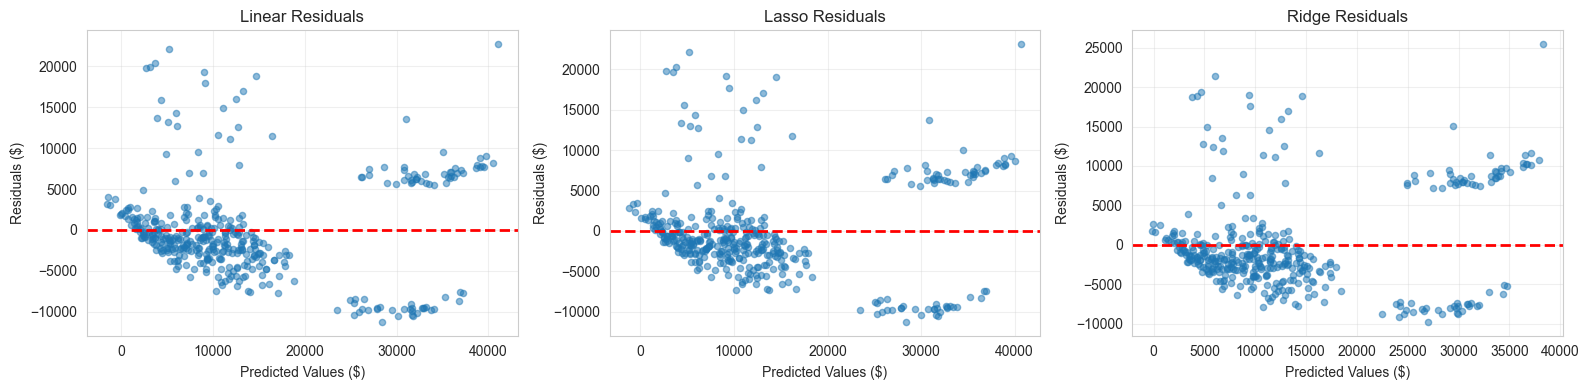

In [ ]:
if df is not None:
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    
    models_data = [('Linear', y_test_lr), ('Lasso', y_test_lasso), ('Ridge', y_test_ridge)]
    
    for idx, (name, y_pred) in enumerate(models_data):
        residuals = y_test - y_pred
        axes[idx].scatter(y_pred, residuals, alpha=0.5, s=20)
        axes[idx].axhline(y=0, color='r', linestyle='--', lw=2)
        axes[idx].set_xlabel('Predicted Values ($)')
        axes[idx].set_ylabel('Residuals ($)')
        axes[idx].set_title(f'{name} Residuals')
        axes[idx].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


## 9. Key Findings & Conclusions

1. **Regularization matters:** Ridge/Lasso outperform unregularized Linear by reducing overfitting
2. **Ridge vs Lasso tradeoff:** Ridge better for multicollinear features (shrinks all); Lasso selects subset
3. **Feature importance:** Smoker status strongest predictor; age and BMI also significant
4. **Non-linearity:** Smoking effect non-linear (much higher costs); linear models capture average effect
5. **Optimal alpha:** Strong regularization (alpha~10-100) needed for test stability
6. **Recommendation:** Ridge Regression best overall - balances bias-variance, handles multicollinearity